##### importing libraries

In [1]:
import os
import cv2
from random import shuffle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

##### extracting data from local dir

In [2]:
data = {
    'imgs' : [],
    'labels' : []
}

datapath = r"C:\Users\US593\Work\Datasets\Pneumonia_Classification\data\chest_xray"
count = 0 

for classes in os.listdir(datapath):
    classes_path = os.path.join(datapath,classes)
    class_name = classes
    for filename in os.listdir(classes_path):
        if filename is not None: 
            data['labels'].append(class_name)
            filepath = os.path.join(classes_path,filename)
            img = cv2.imread(filepath)
            resized_img = cv2.resize(img,(224,224))
            img_gray = cv2.cvtColor(resized_img,cv2.COLOR_BGR2GRAY)
            data['imgs'].append(img_gray)
            count += 1
            if count%1000 == 0 : 
                print(f"processed {count}")

processed 1000
processed 2000
processed 3000
processed 4000
processed 5000


##### shuffling data for better visualization

In [3]:
combined = list(zip(data['imgs'], data['labels']))
shuffle(combined)
data['shuffled_imgs'],data['shuffled_labels'] = zip(*combined)

##### data visualization

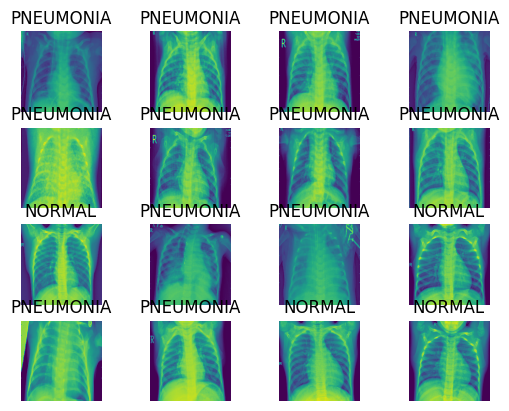

In [4]:
i = 0
for label , img in zip(data['shuffled_labels'][:16],data['shuffled_imgs'][:16]):
    ax = plt.subplot(4,4,i+1) # create subplot with in grid with (rows,columns,index)
    plt.imshow(img)
    plt.title(label)
    plt.axis('off')
    i += 1
    if i == 16:
        break

In [5]:
# nrg -> noise - remove - gaussian
data['nrg_imgs'] = []
count = 0
for img in data['shuffled_imgs']:
    gaus = cv2.GaussianBlur(img,(5,5),0)
    data['nrg_imgs'].append(gaus)
    count += 1
    if count%1000 == 0 : 
        print(f"processed {count}")

processed 1000
processed 2000
processed 3000
processed 4000
processed 5000


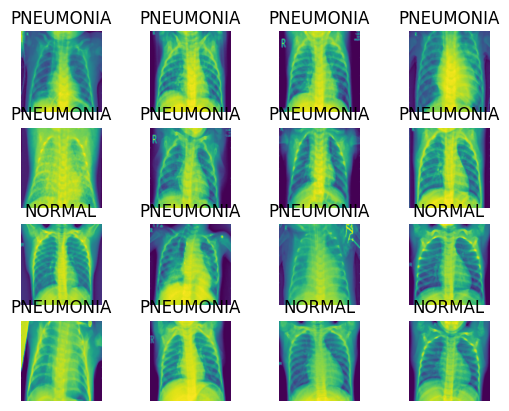

In [6]:
i = 0
for label , img in zip(data['shuffled_labels'][:16],data['nrg_imgs'][:16]):
    ax = plt.subplot(4,4,i+1) # create subplot with in grid with (rows,columns,index)
    plt.imshow(img)
    plt.title(label)
    plt.axis('off')
    i += 1
    if i == 16:
        break

In [7]:
# ahe -> adaptive_histogram_equalization
data['ahe'] = []
count = 0
for img in data['nrg_imgs']:
    clahe = cv2.createCLAHE(clipLimit = 3)
    final_img = clahe.apply(img)
    data['ahe'].append(final_img)
    count += 1
    if count%1000 == 0 : 
        print(f"processed {count}")

processed 1000
processed 2000
processed 3000
processed 4000
processed 5000


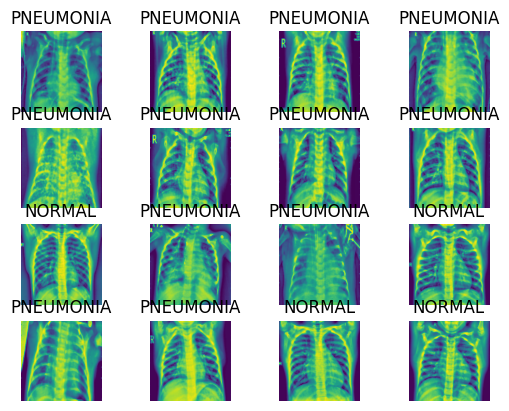

In [8]:
i = 0
for label , img in zip(data['shuffled_labels'][:16],data['ahe'][:16]):
    ax = plt.subplot(4,4,i+1) # create subplot with in grid with (rows,columns,index)
    plt.imshow(img)
    plt.title(label)
    plt.axis('off')
    i += 1
    if i == 16:
        break

##### label_encoding

In [9]:
data.keys()

dict_keys(['imgs', 'labels', 'shuffled_imgs', 'shuffled_labels', 'nrg_imgs', 'ahe'])

In [10]:
labels = np.array(data['shuffled_labels'])

In [11]:
le = LabelEncoder()
encoded_labels = le.fit_transform(labels)

In [12]:
encoded_labels.shape

(5856,)

In [13]:
encoded_labels[:5]

array([1, 1, 1, 1, 1], dtype=int64)

##### 0 -> normal
##### 1 -> pneumonia

In [14]:
class_names =  {0 : 'Normal', 1 : 'Pneumonia'}

In [15]:
import json
with open("class_names.json","w") as f:
    f.write(json.dumps(class_names))

##### flattening-out images

In [16]:
images = np.array(data['ahe'])

In [17]:
images.shape

(5856, 224, 224)

In [18]:
flattened_imgs = np.reshape(images, (5856,50176))

In [19]:
flattened_imgs.shape

(5856, 50176)

##### normalization

In [20]:
flattened_imgs[0][:10]

array([249, 246, 235, 229, 221, 219, 208, 192, 175, 155], dtype=uint8)

In [21]:
scaler = MinMaxScaler()

In [22]:
scaled_imgs = scaler.fit_transform(flattened_imgs)

In [23]:
scaled_imgs[0][:10]

array([0.97637795, 0.96456693, 0.92125984, 0.8976378 , 0.86614173,
       0.85770751, 0.81422925, 0.7519685 , 0.68503937, 0.60629921])

##### trian_test_split

In [24]:
from sklearn.model_selection import train_test_split

In [25]:
x_train,x_test,y_train,y_test = train_test_split(flattened_imgs, encoded_labels, test_size = 0.2, stratify = encoded_labels, shuffle = True, random_state = 23)

In [26]:
x_train.shape

(4684, 50176)

In [27]:
y_train.shape

(4684,)

In [28]:
x_test.shape

(1172, 50176)

In [29]:
y_test.shape

(1172,)

##### normal and pneumonia chest xray image for testing

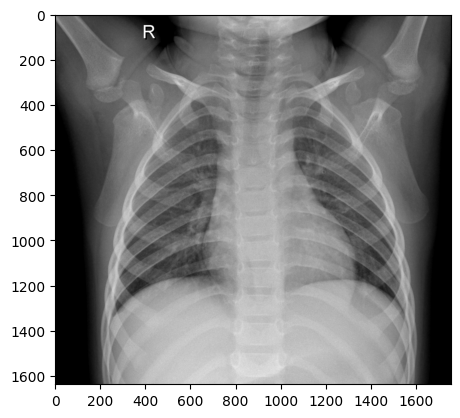

In [30]:
test_normal = cv2.imread('test_normal.jpeg')
plt.imshow(test_normal)

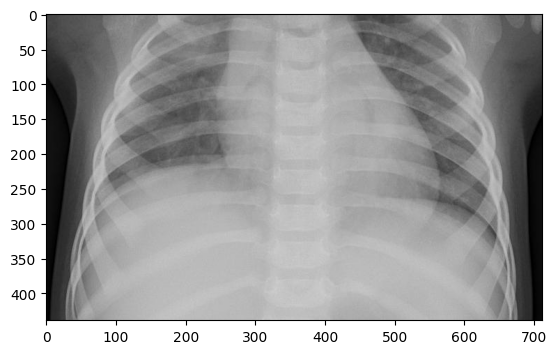

In [31]:
test_pneumonia = cv2.imread('test_pneumonia.jpeg')
plt.imshow(test_pneumonia)

##### detect_func

In [32]:
def detect(img,model,class_names):
    img_resized = cv2.resize(img, (224,224))
    img_gray = cv2.cvtColor(img_resized,cv2.COLOR_BGR2GRAY)
    gaus = cv2.GaussianBlur(img_gray,(5,5),0)
    clahe = cv2.createCLAHE(clipLimit = 3)
    final_img = clahe.apply(gaus)
    flattened_img = np.reshape(final_img, (1,50176))
    flat_data = np.array(flattened_img)
    prediction = model.predict(flat_data)[0]
    confidence_score_array = model.predict_proba(flat_data)[0]
    class_name = class_names[prediction]
    confidence_score = f"{confidence_score_array[prediction] * 100} %"
    results = {}
    results['detection'] = class_name
    results['score'] = confidence_score
    
    return results

##### Decision Trees Model Evaluation

In [34]:
with open('decision_tree_model.p', 'rb') as file:
    model1 = pickle.load(file)

In [35]:
model1.score(x_train,y_train)

0.9481212638770282

In [36]:
model1.score(x_test,y_test)

0.9539249146757679

In [37]:
detect(test_normal,model1,class_names)

{'detection': 'Normal', 'score': '100.0 %'}

In [38]:
detect(test_pneumonia,model1,class_names)

{'detection': 'Pneumonia', 'score': '100.0 %'}

##### Random Forest Model Evaluation

In [39]:
with open('random_forest_model.p', 'rb') as file:
    model2 = pickle.load(file)

In [40]:
model2.score(x_train,y_train)

0.9861229718189581

In [41]:
model2.score(x_test,y_test)

0.9914675767918089

In [42]:
detect(test_normal,model2,class_names)

{'detection': 'Normal', 'score': '95.0 %'}

In [43]:
detect(test_pneumonia,model2,class_names)

{'detection': 'Pneumonia', 'score': '99.0 %'}

##### Naive Bayes Model Evaluation

In [44]:
with open('naive_bayes_model.p', 'rb') as file:
    model3 = pickle.load(file)

In [45]:
model3.score(x_train,y_train)

0.8541844577284372

In [46]:
model3.score(x_test,y_test)

0.8592150170648464

In [47]:
detect(test_normal,model3,class_names)

{'detection': 'Normal', 'score': '100.0 %'}

In [48]:
detect(test_pneumonia,model3,class_names)

{'detection': 'Pneumonia', 'score': '100.0 %'}